In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load data

In [10]:
# Load dynamic data
# Craft folder path
dynamic_root_dir = '../2022-12-14T0014-mia-niid-dynamic/'
fc_root_dir = '../2022-12-32T0503-mia-niid-fullyconnected-2shards/'
static_root_dir = './'


env = "NIID-full-model-sharing-dynamic"
FILE_NAMES = ['privacy-summary-PRE-STEP.json', 'privacy-summary-POST-STEP.json']
location = FILE_NAMES[1]
MAX_PROCESSES = 32
MAX_MACHINES =  3
MAX_ITERATIONS=2500

machine_folder = 'sacs0{}'
machine_folder2= 'machine{}'
privacy_folder = 'privacy'
summary_folder = 'summary'
process_foilder = '{}'


# Load data
dynamic_data = pd.DataFrame({})
fc_data = pd.DataFrame({})
static_data = pd.DataFrame({})

for location in FILE_NAMES:
    for machine in range(MAX_MACHINES):
        for rank in range(MAX_PROCESSES):
            file = os.path.join(dynamic_root_dir, machine_folder.format(machine*2+1), machine_folder2.format(machine),privacy_folder, summary_folder, process_foilder.format(machine*MAX_PROCESSES+rank), location)
            tmp_df = pd.read_json(file)
            tmp_df = tmp_df[tmp_df.iteration < MAX_ITERATIONS]
            # tmp_df['location_of_attack']= file.split('.')[0]
            dynamic_data = pd.concat([dynamic_data,tmp_df])

            file = os.path.join(fc_root_dir, machine_folder.format(machine*2+1), machine_folder2.format(machine),privacy_folder, summary_folder, process_foilder.format(machine*MAX_PROCESSES+rank), location)
            tmp_df = pd.read_json(file)
            tmp_df = tmp_df[tmp_df.iteration < MAX_ITERATIONS]
            fc_data = pd.concat([fc_data,tmp_df])

            file = os.path.join(static_root_dir, machine_folder.format(machine*2+1), machine_folder2.format(machine),privacy_folder, summary_folder, process_foilder.format(machine*MAX_PROCESSES+rank), location)
            tmp_df = pd.read_json(file)
            tmp_df = tmp_df[tmp_df.iteration < MAX_ITERATIONS]
            static_data = pd.concat([static_data,tmp_df])
           
# Print
dynamic_data

slice feature slice value  train size  test size  \
0            Entire dataset                     520        520   
1                     class           1         260         53   
2                     class           5         260         37   
3      correctly_classified        True         260         37   
4      correctly_classified       False         260        483   
...                     ...         ...         ...        ...   
19986                 class           7          71         56   
19987                 class           8         133         60   
19988                 class           9          96         69   
19989  correctly_classified        True         438        366   
19990  correctly_classified       False         162        234   

            attack type  Attacker advantage  Positive predictive value  \
0      THRESHOLD_ATTACK            0.640385                   1.000000   
1      THRESHOLD_ATTACK            0.125980                   0.889158   
2      THRESHOLD_ATTACK            0.180457                   0.886729   
3      THRESHOLD_ATTACK            0.180457                   0.886729   
4      THRESHOLD_ATTACK            0.606577                   1.000000   
...                 ...                 ...                        ...   
19986  THRESHOLD_ATTACK            0.160966                   1.000000   
19987  THRESHOLD_ATTACK            0.083208                   1.000000   
19988  THRESHOLD_ATTACK            0.146739                   0.906355   
19989  THRESHOLD_ATTACK            0.074145                   0.674124   
19990  THRESHOLD_ATTACK            0.166667                   0.675000   

            AUC  iteration location_of_attack  
0      0.881309          1           PRE-STEP  
1      0.466473          1           PRE-STEP  
2      0.457069          1           PRE-STEP  
3      0.457069          1           PRE-STEP  
4      0.862629          1           PRE-STEP  
...         ...        ...                ...  
19986  0.433853       2499          POST-STEP  
19987  0.490100       2499          POST-STEP  
19988  0.519173       2499          POST-STEP  
19989  0.524453       2499          POST-STEP  
19990  0.606917       2499          POST-STEP  

[2514391 rows x 10 columns]

# Group by iterations and plot moving min,max,avg

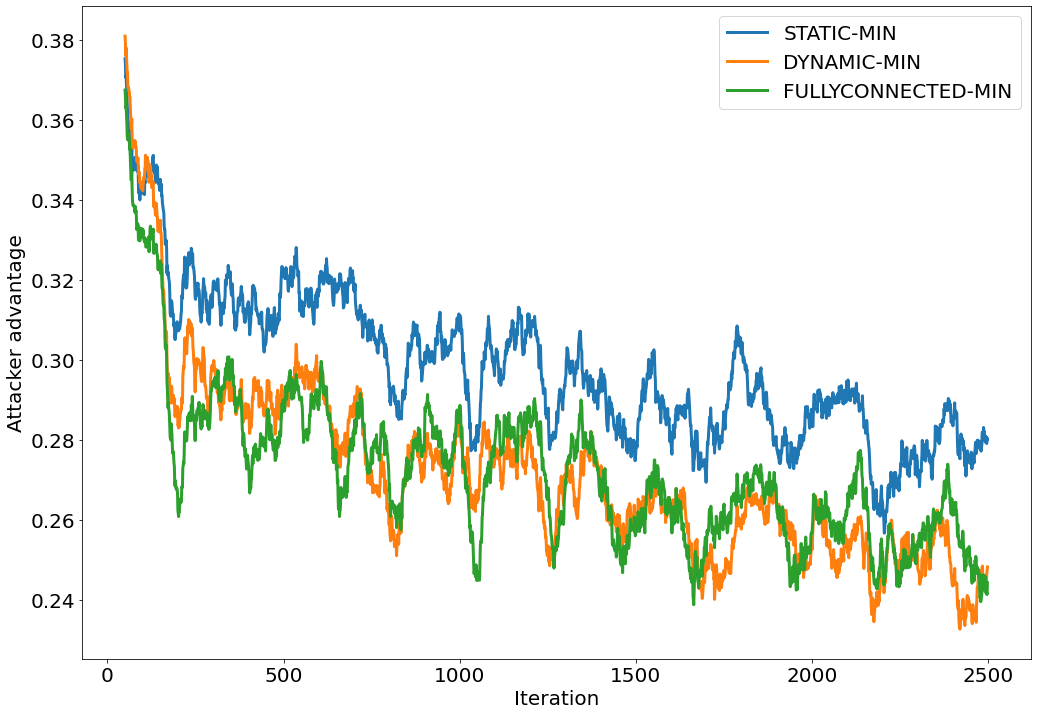

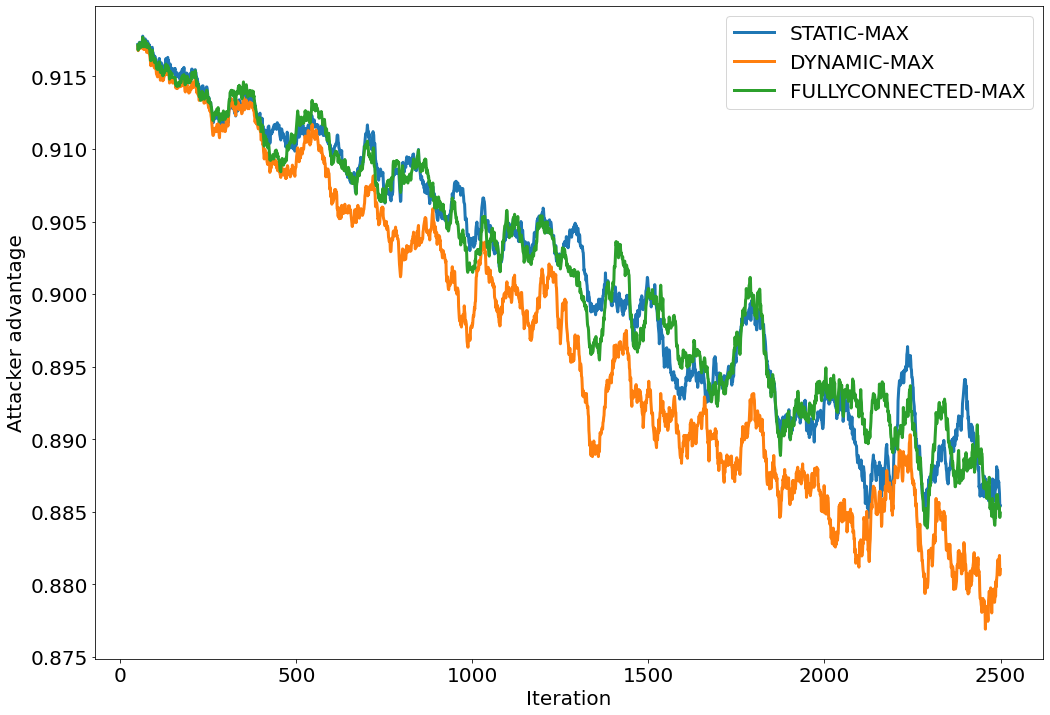

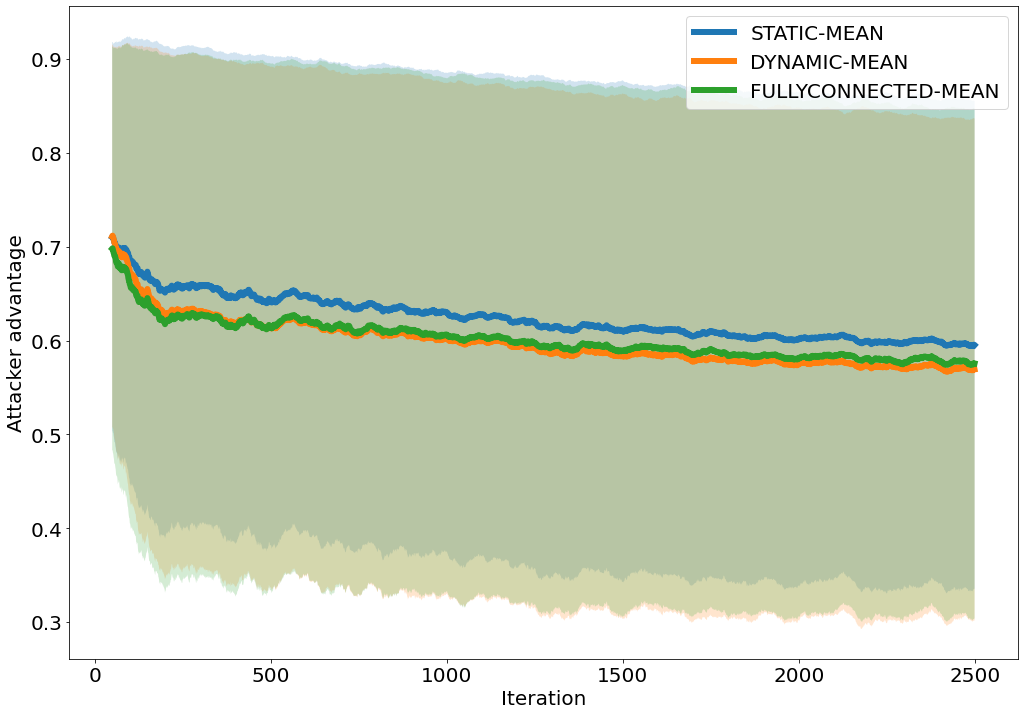

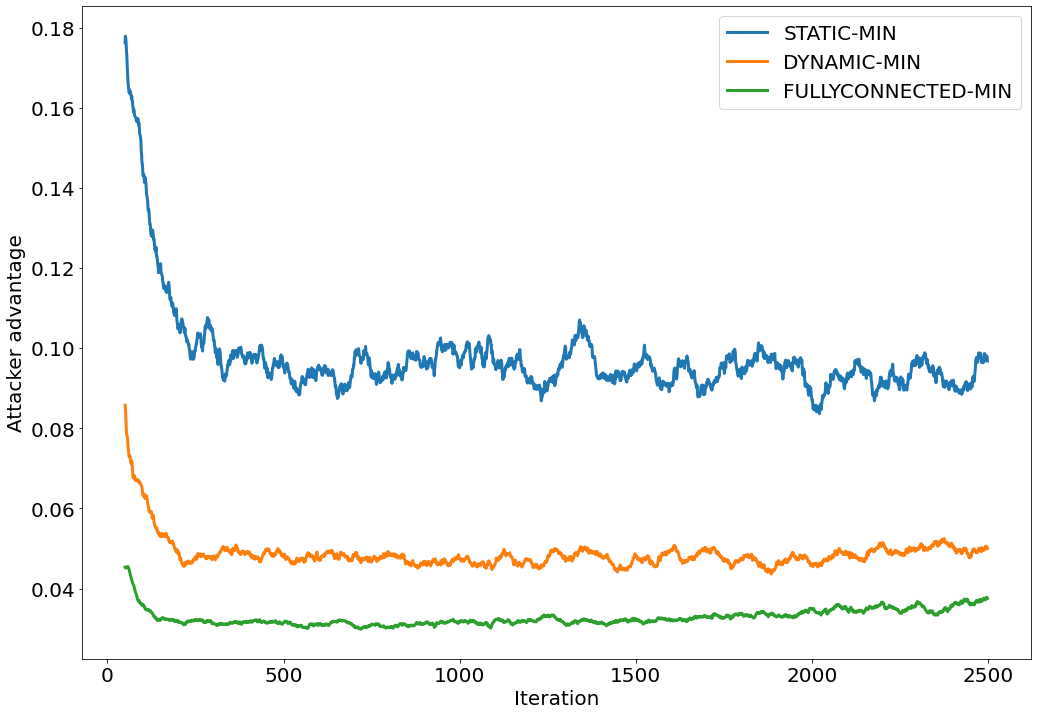

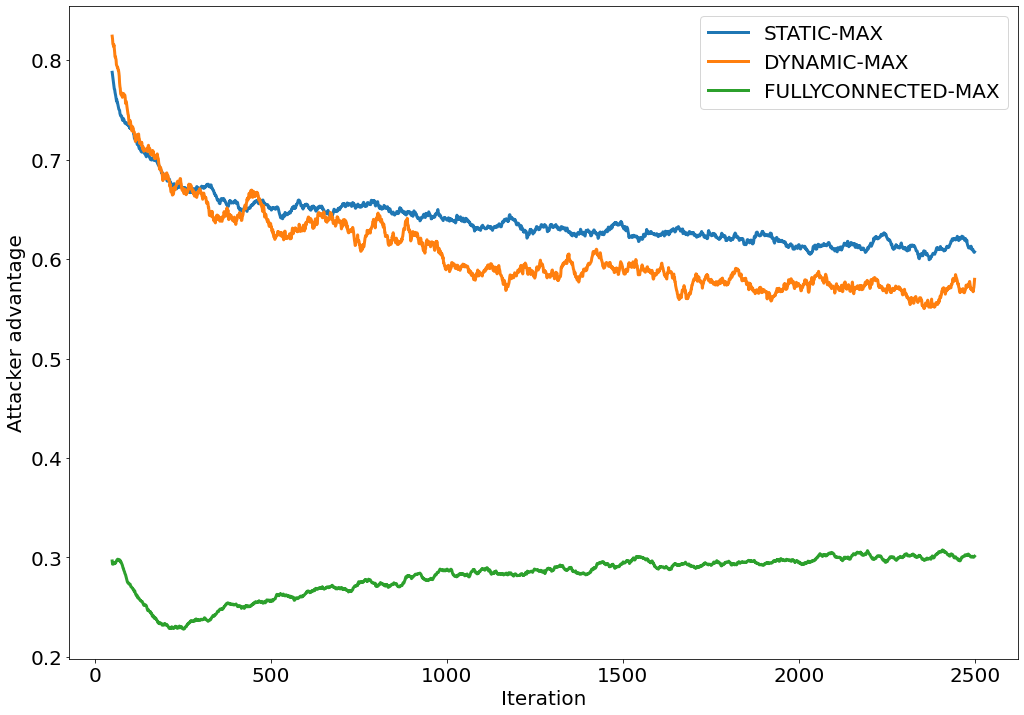

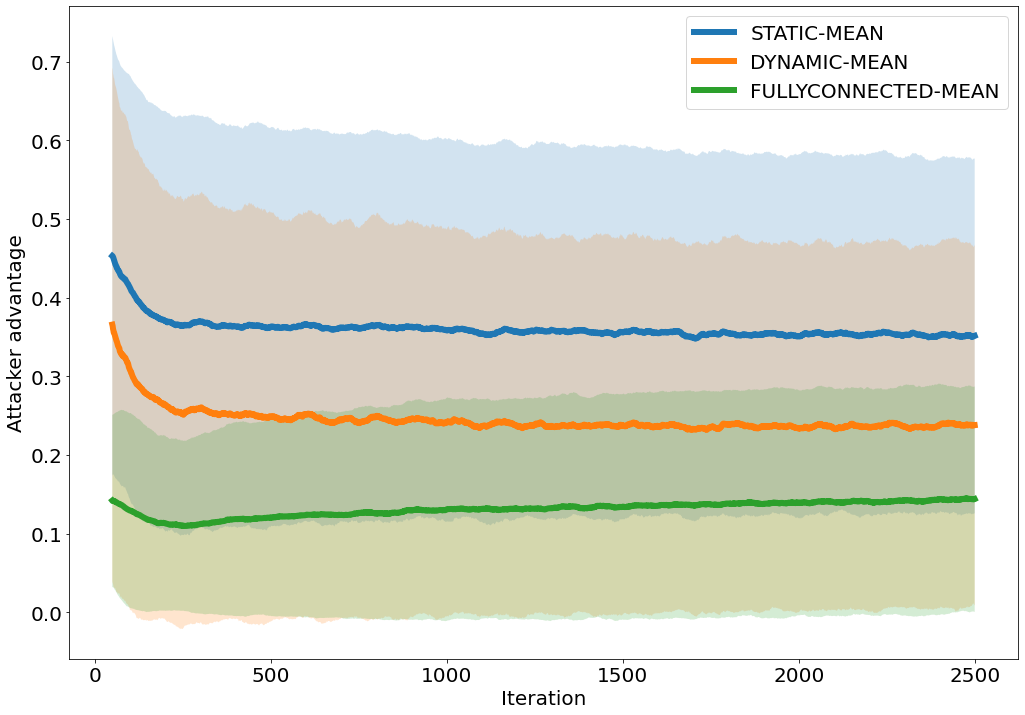

In [11]:
# Define plot attributes
fontsize=20
linewidth = 5
alpha = 0.2
figsize = (17,12)

# Group by iteration and extracted mean and std
entire_dataset = static_data[static_data['slice feature'] == 'Entire dataset']
dynamic_entire_dataset = dynamic_data[dynamic_data['slice feature']== 'Entire dataset']
fc_entire_dataset = fc_data[fc_data['slice feature']== 'Entire dataset']
metrics = ["Attacker advantage","AUC"]
metrics = [metrics[0]]
window_size = 50
linewidth = 3
for metric in metrics:
    for location in static_data.location_of_attack.unique():
        location_label = "".join(location.split('-'))

        # Extract relevant data
        nondynamic_location_data = entire_dataset[entire_dataset.location_of_attack==location]
        dynamic_location_data = dynamic_entire_dataset[dynamic_entire_dataset.location_of_attack==location]
        fc_location_data = fc_entire_dataset[fc_entire_dataset.location_of_attack==location]

        # Aggregate
        columns = ['iteration', 'Attacker advantage', 'AUC']
        nondynamic_averaged = nondynamic_location_data[columns].groupby('iteration').agg([np.max, np.min, np.mean, np.std])
        dynamic_averaged = dynamic_location_data[columns].groupby('iteration').agg([np.max, np.min, np.mean, np.std])
        fc_averaged = fc_location_data[columns].groupby('iteration').agg([np.max, np.min, np.mean, np.std])
        
        # Plot
        nondynamic_metric_data = nondynamic_averaged[metric].rolling(window=window_size).mean()
        dynamic_metric_data = dynamic_averaged[metric].rolling(window=window_size).mean()
        fc_metric_data = fc_averaged[metric].rolling(window=window_size).mean()
        
        nondynamic_max, nondynamic_min = nondynamic_metric_data["amax"], nondynamic_metric_data["amin"]
        dynamic_max, dynamic_min = dynamic_metric_data["amax"], dynamic_metric_data["amin"]
        fc_max, fc_min = fc_metric_data["amax"], fc_metric_data["amin"]


        plt.figure(figsize=figsize)
        plt.plot(nondynamic_averaged.index, nondynamic_min,label="STATIC-"+'MIN', linewidth=linewidth)
        plt.plot(dynamic_averaged.index, dynamic_min,label="DYNAMIC-"+'MIN', linewidth=linewidth)
        plt.plot(fc_averaged.index, fc_min,label="FULLYCONNECTED-"+'MIN', linewidth=linewidth)
        plt.xlabel('Iteration', fontsize=fontsize)
        # plt.title("{env}    |   {metric}    |  comparison".format(env = env, metric = metric))
        plt.ylabel(metric, fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        # plt.savefig('NIID-min-{}={}.jpg'.format(location, metric))
        # plt.savefig('NIID-min-{}-{}.svg'.format(location, metric))

        plt.figure(figsize=figsize)
        plt.plot(nondynamic_averaged.index, nondynamic_max,label="STATIC-"+'MAX',linewidth=linewidth)
        plt.plot(dynamic_averaged.index, dynamic_max,label="DYNAMIC-"+'MAX',linewidth=linewidth)
        plt.plot(fc_averaged.index, fc_max,label="FULLYCONNECTED-"+'MAX',linewidth=linewidth)
        # plt.title("{env}    |   {metric}    |  comparison".format(env = env, metric = metric))
        plt.ylabel(metric, fontsize=fontsize)
        plt.xlabel('Iteration', fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        # plt.savefig('NIID-max-{}={}.jpg'.format(location, metric))
        # plt.savefig('NIID-max-{}-{}.svg'.format(location_label, metric))

        plt.figure(figsize=figsize)
        mean = nondynamic_metric_data['mean']
        std = nondynamic_metric_data['std']
        plt.plot(nondynamic_averaged.index, mean ,label="STATIC-MEAN",linewidth=linewidth*2)
        plt.fill_between(nondynamic_averaged.index, mean-2*std, mean+2*std, alpha=alpha);

        mean = dynamic_metric_data['mean']
        std = dynamic_metric_data['std']
        plt.plot(dynamic_averaged.index, dynamic_metric_data['mean'],label="DYNAMIC-MEAN",linewidth=linewidth*2)
        plt.fill_between(dynamic_averaged.index, mean-2*std, mean+2*std, alpha=alpha);

        mean = fc_metric_data['mean']
        std = fc_metric_data['std']
        plt.plot(fc_averaged.index, fc_metric_data['mean'],label="FULLYCONNECTED-MEAN",linewidth=linewidth*2)
        plt.fill_between(fc_averaged.index, mean-2*std, mean+2*std, alpha=alpha)
        # plt.title("{env}    |   {metric}    |  comparison".format(env = env, metric = metric))
        plt.ylabel(metric, fontsize=fontsize)
        plt.xlabel('Iteration', fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        # plt.savefig('NIID-mean-{}={}.jpg'.format(location, metric))
        # plt.savefig('NIID-mean-{}-{}.svg'.format(location, metric))